In [1]:
import scvelo as scv
import pickle
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", "DeprecationWarning")

In [2]:
with open("../data/merge_velocity.pickle", 'rb') as f:
    merge = pickle.load(f)

In [3]:
DCtum = merge[merge.obs["Population"].isin(["cDC1", "cDC2", "Mature_DC"]),]
DCtum = DCtum[DCtum.obs["Stage"] == "Healthy",]

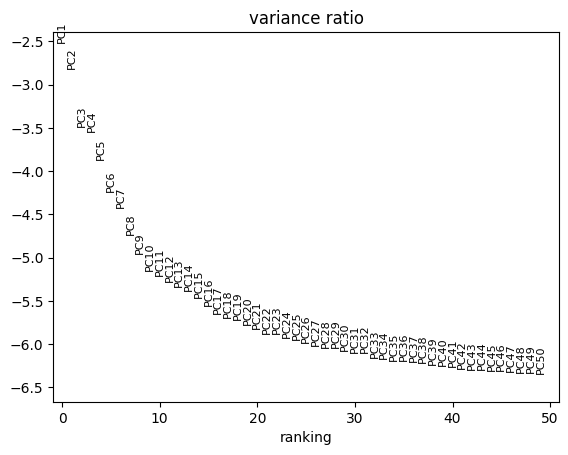

2024-06-19 10:18:34,071 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-06-19 10:18:35,039 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-06-19 10:18:35,055 - harmonypy - INFO - Iteration 1 of 10
2024-06-19 10:18:35,757 - harmonypy - INFO - Iteration 2 of 10
2024-06-19 10:18:36,372 - harmonypy - INFO - Iteration 3 of 10
2024-06-19 10:18:36,973 - harmonypy - INFO - Iteration 4 of 10
2024-06-19 10:18:37,521 - harmonypy - INFO - Iteration 5 of 10
2024-06-19 10:18:37,789 - harmonypy - INFO - Iteration 6 of 10
2024-06-19 10:18:38,041 - harmonypy - INFO - Iteration 7 of 10
2024-06-19 10:18:38,259 - harmonypy - INFO - Iteration 8 of 10
2024-06-19 10:18:38,455 - harmonypy - INFO - Iteration 9 of 10
2024-06-19 10:18:38,679 - harmonypy - INFO - Iteration 10 of 10
2024-06-19 10:18:38,859 - harmonypy - INFO - Stopped before convergence


In [4]:
sc.pp.normalize_total(DCtum)
sc.pp.log1p(DCtum)
sc.pp.highly_variable_genes(DCtum)
sc.tl.pca(DCtum)
sc.pl.pca_variance_ratio(DCtum, n_pcs=50, log=True)
sc.external.pp.harmony_integrate(DCtum, "orig.ident")

sc.pp.neighbors(DCtum,  use_rep = "X_pca_harmony", )
sc.tl.umap(DCtum)
sc.tl.louvain(DCtum, resolution = 0.5)

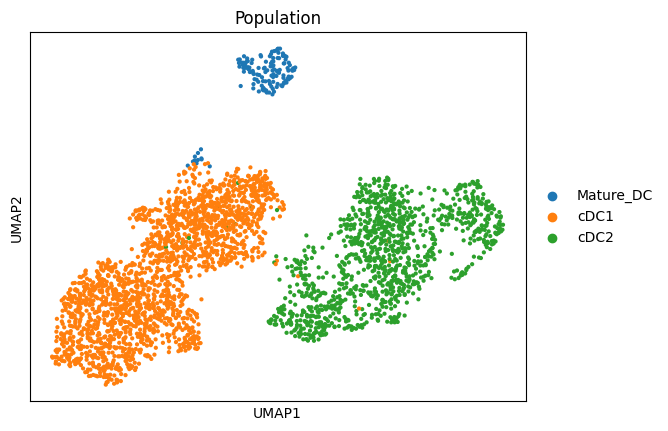

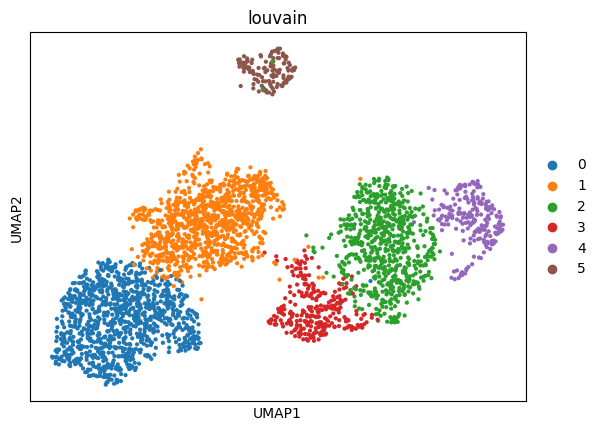

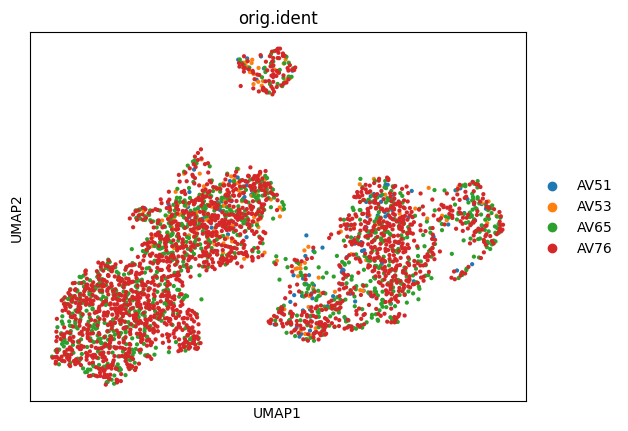

In [5]:
sc.pl.umap(DCtum, color = 'Population')
sc.pl.umap(DCtum, color = 'louvain')
sc.pl.umap(DCtum, color = 'orig.ident')

In [6]:
# 0 vs 1 ?

In [8]:
DCtum.raw.var.index = DCtum.raw.var._index 

categories: 0, 1, 2, etc.
var_group_labels: 0


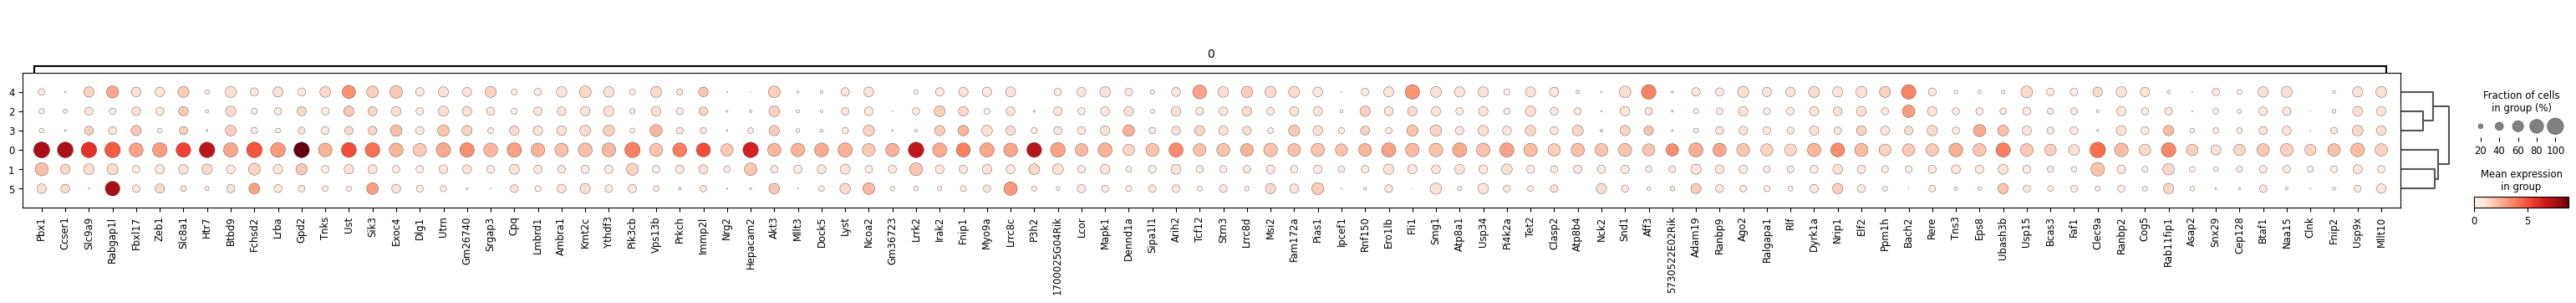

categories: Mature_DC, cDC1, cDC2
var_group_labels: 0


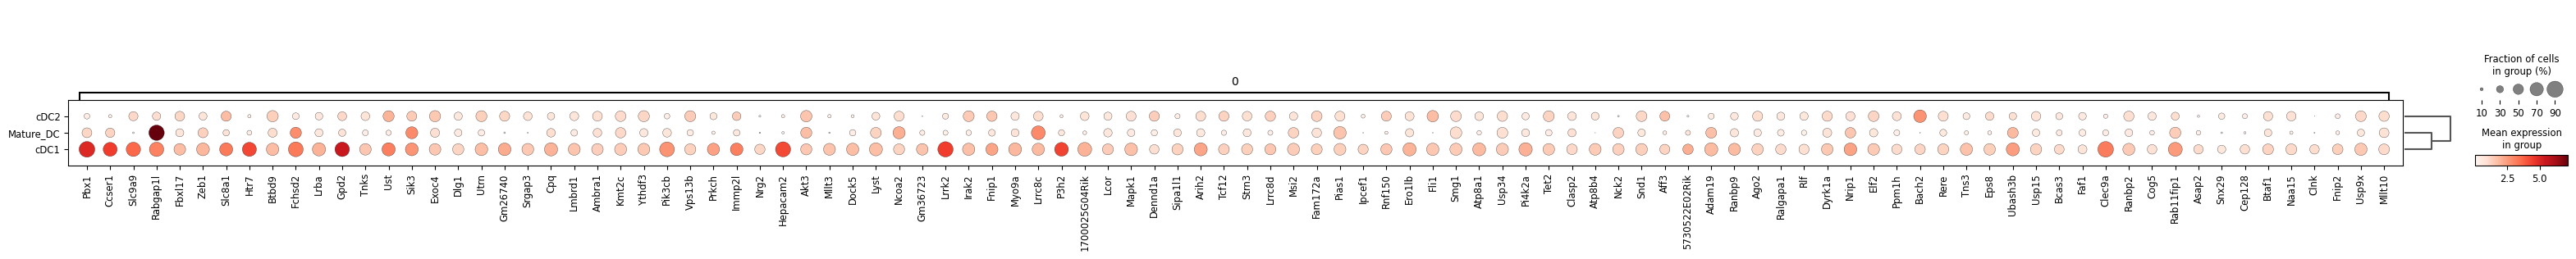

In [13]:
# DEG cluster 5 vs autre cDC1
import matplotlib
FIGSIZE = (10, 10)
matplotlib.rcParams["figure.figsize"] = FIGSIZE
sc.tl.rank_genes_groups(DCtum, groups = ["0"], reference="1", groupby="louvain")
sc.tl.filter_rank_genes_groups(DCtum, min_fold_change=-1000, min_in_group_fraction = 0.1)
sc.pl.rank_genes_groups_dotplot(DCtum, groups = ["0"], groupby="louvain", key = "rank_genes_groups_filtered", n_genes=100)
sc.pl.rank_genes_groups_dotplot(DCtum, groups = ["0"], groupby="Population", key = "rank_genes_groups_filtered", n_genes=100)


In [25]:
df = sc.get.rank_genes_groups_df(DCtum, group = "0", key = "rank_genes_groups_filtered")
df = df.dropna()
df_sorted = df.sort_values("logfoldchanges", ascending = False)

In [32]:
df_stat = df_sorted[df_sorted["pvals_adj"] < 0.01]
df_stat["-log_pval"] = -1*np.log10(df_stat["pvals_adj"])

liste = []
threshold = 0.58
for i in df_stat.values: #2 = foldchange, 4 = pval_adj
    if i[2] > threshold:
        liste.append("UP")
    elif i[2] < -threshold : 
        liste.append("DOWN")
    else:
        liste.append("NONE")
df_stat["assignation"] = liste

In [33]:
df_up = df_stat[df_stat["assignation"] == "UP"]
print(f"{df_up.shape[0]} DEG with logFC > {threshold}, showing top 20 : ")
df_up[0:20]

3461 DEG with logFC > 0.58, showing top 20 : 


,names,scores,logfoldchanges,pvals,pvals_adj,-log_pval,assignation
76,Gpd2,22.219542,10.364797,2.018313e-91,6.616961e-89,88.179341,UP
18,Ccser1,27.274118,9.287045,5.250954e-128,6.103518e-125,124.214420,UP
140,P3h2,19.418501,8.725699,1.397338e-72,2.398169e-70,69.620120,UP
68,Htr7,22.561985,8.594546,1.265509e-93,4.258104e-91,90.370784,UP
14,Pbx1,27.989595,8.133628,2.287104e-135,4.498909e-132,131.346893,UP
128,Lrrk2,20.012348,7.311886,2.275103e-77,4.441139e-75,74.352506,UP
31,Slc9a9,25.903809,7.233662,1.227394e-117,9.231447e-115,114.034730,UP
67,Slc8a1,22.610363,7.092721,1.102452e-93,3.758921e-91,90.424937,UP
78,Ust,22.078964,6.603512,2.105375e-90,6.815018e-88,87.166533,UP
118,Hepacam2,20.331560,6.534731,1.248045e-79,2.553200e-77,76.592915,UP


In [34]:
df_down = df_stat[df_stat["assignation"] == "DOWN"]
df_down = df_down.sort_values("logfoldchanges", ascending = True)
print(f"{df_down.shape[0]} DEG with logFC < {-threshold}, showing top 20 : ")
df_down[0:20]

5 DEG with logFC < -0.58, showing top 20 : 


,names,scores,logfoldchanges,pvals,pvals_adj,-log_pval,assignation
25553,Fdps,-3.886129,-0.732302,0.000106,0.000644,3.190887,DOWN
25555,Mrps11,-4.020648,-0.706066,0.000060,0.000381,3.419378,DOWN
25549,Wdr18,-3.729111,-0.656849,0.000198,0.001161,2.935149,DOWN
25535,Tspan17,-3.318944,-0.632275,0.000921,0.004849,2.314310,DOWN
25525,Gstp1,-3.127932,-0.598251,0.001787,0.008953,2.048041,DOWN


<Axes: xlabel='gene_ratio', ylabel='name'>

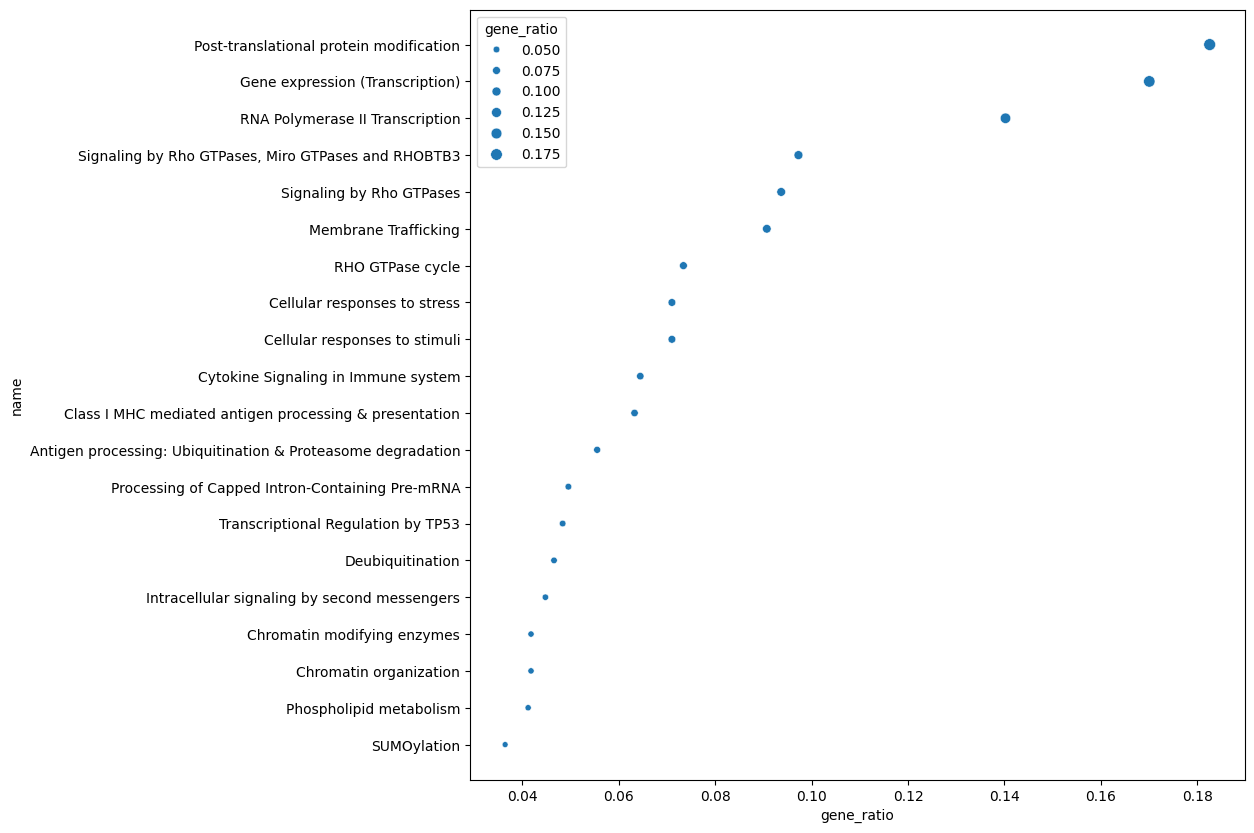

In [35]:
up_Early_vs_Healthy_cDC1 = list(df_up["names"].values)
df_enrich = sc.queries.enrich(up_Early_vs_Healthy_cDC1,org = "mmusculus")

np.unique(df_enrich["source"])

df_enrich["-log_pval"] = -1*np.log10(df_enrich["p_value"])
df_enrich["gene_ratio"] = [df_enrich.loc[i, "intersection_size"] / df_enrich.loc[i, "query_size"] for i in df_enrich.index]

temp = df_enrich[df_enrich["source"] == "REAC"]

test = temp.sort_values("gene_ratio", ascending = False)

sns.scatterplot(test[0:20], x = "gene_ratio", y = "name", size = "gene_ratio")

<Axes: xlabel='gene_ratio', ylabel='name'>

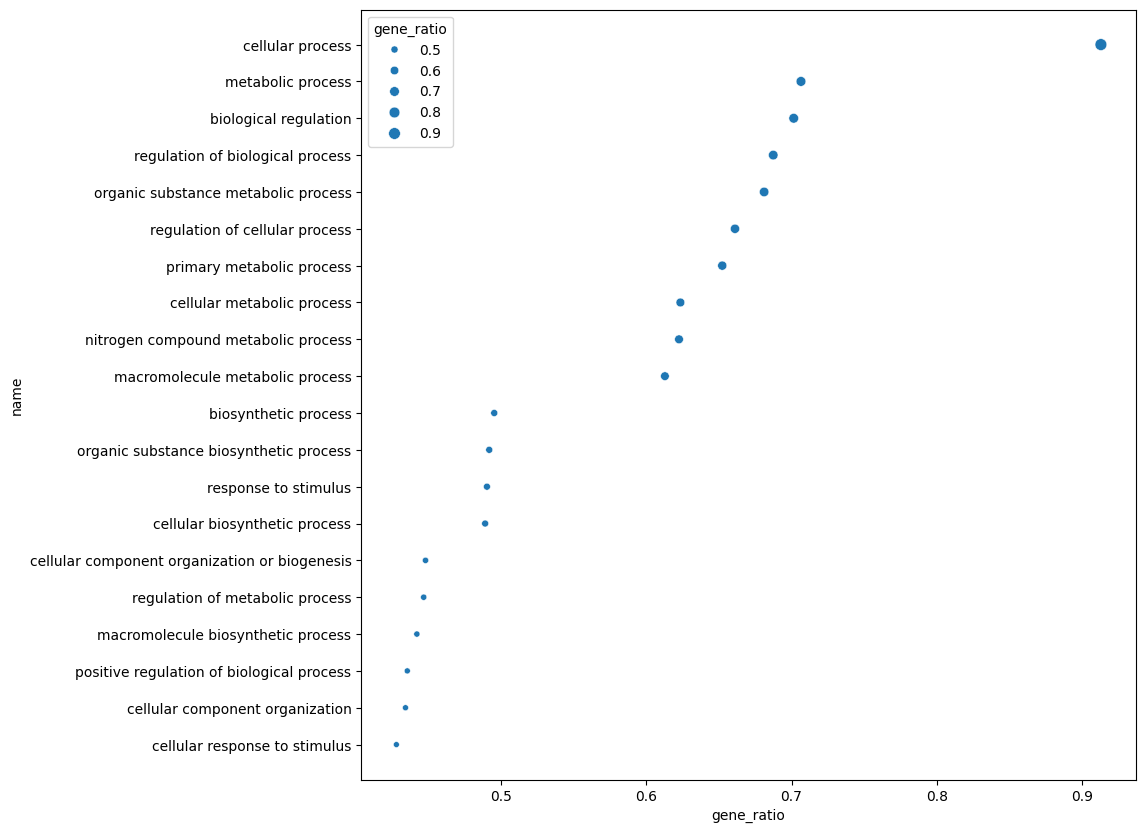

In [36]:
up_Early_vs_Healthy_cDC1 = list(df_up["names"].values)
df_enrich = sc.queries.enrich(up_Early_vs_Healthy_cDC1,org = "mmusculus")

np.unique(df_enrich["source"])

df_enrich["-log_pval"] = -1*np.log10(df_enrich["p_value"])
df_enrich["gene_ratio"] = [df_enrich.loc[i, "intersection_size"] / df_enrich.loc[i, "query_size"] for i in df_enrich.index]

temp = df_enrich[df_enrich["source"] == "GO:BP"]

test = temp.sort_values("gene_ratio", ascending = False)

sns.scatterplot(test[0:20], x = "gene_ratio", y = "name", size = "gene_ratio")

<Axes: xlabel='gene_ratio', ylabel='name'>

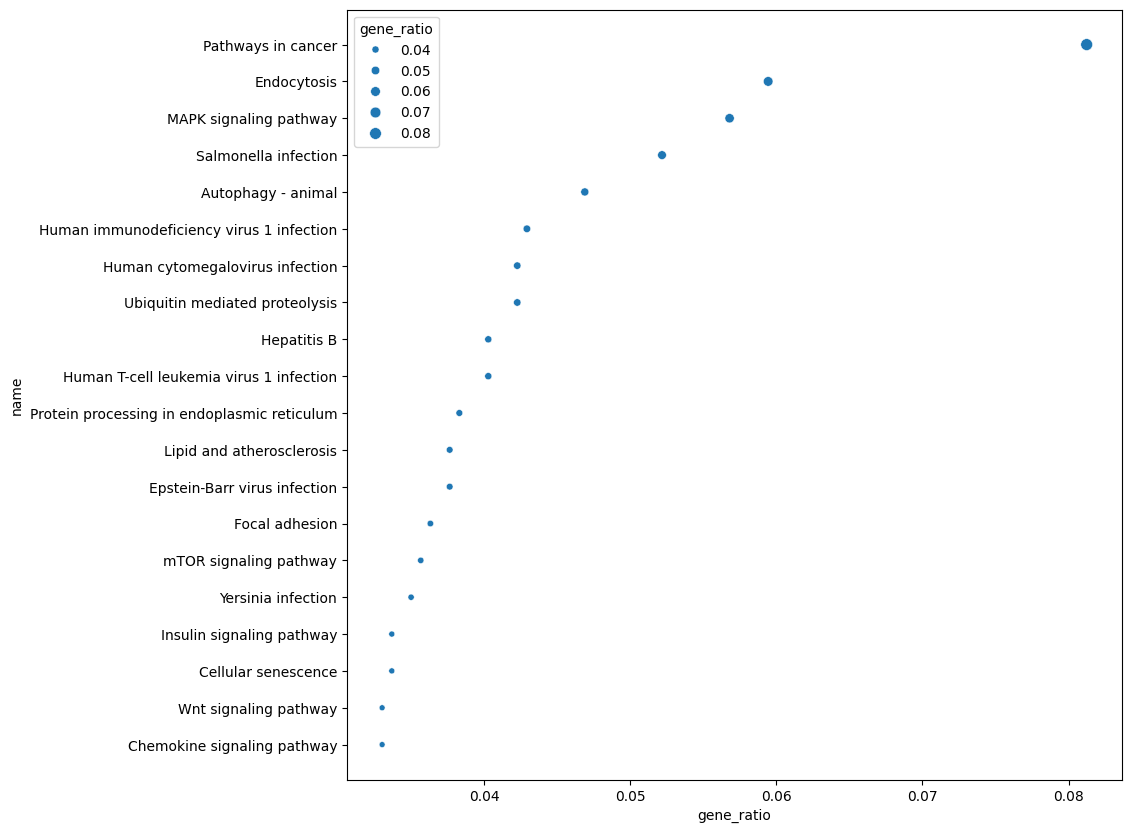

In [37]:
up_Early_vs_Healthy_cDC1 = list(df_up["names"].values)
df_enrich = sc.queries.enrich(up_Early_vs_Healthy_cDC1,org = "mmusculus")

np.unique(df_enrich["source"])

df_enrich["-log_pval"] = -1*np.log10(df_enrich["p_value"])
df_enrich["gene_ratio"] = [df_enrich.loc[i, "intersection_size"] / df_enrich.loc[i, "query_size"] for i in df_enrich.index]

temp = df_enrich[df_enrich["source"] == "KEGG"]

test = temp.sort_values("gene_ratio", ascending = False)

sns.scatterplot(test[0:20], x = "gene_ratio", y = "name", size = "gene_ratio")